## **SATELLITE IMAGE ANALYSIS USING MACHINE LEARNING - TEST TASK**

-Tanmay Delhikar






---



Mount EuroSAT data in Google Drive or Local disk

In [0]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# !unzip -q "/content/drive/My Drive/Colab_Notebooks/EuroSAT.zip"



---



Import libraries

In [0]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import style
from torchvision import models, datasets
from collections import OrderedDict



---



Data Loader Class

In [0]:
class Data_Loader():
    AnnualCrop = "/content/2750/AnnualCrop"
    Forest = "/content/2750/Forest"
    HerbaceousVegetation = "/content/2750/HerbaceousVegetation"
    Highway = "/content/2750/Highway"
    Industrial = "/content/2750/Industrial"
    Pasture = "/content/2750/Pasture"
    PermanentCrop = "/content/2750/PermanentCrop"
    Residential = "/content/2750/Residential"
    River = "/content/2750/River"
    SeaLake = "/content/2750/SeaLake"

    LABELS = {AnnualCrop: 0, Forest: 1, HerbaceousVegetation: 2, Highway: 3, Industrial: 4, Pasture: 5, PermanentCrop: 6, Residential: 7, River: 8, SeaLake: 9}
    training_data = []

    annualCropCount = 0
    forestCount = 0
    herbaceousVegetationCount=0
    highwayCount=0
    industrialCount=0
    pastureCount=0
    permanentCropCount=0
    residentialCount=0
    riverCount=0
    seaLakeCount=0

    def load_data(self):
        for label in self.LABELS:
            print('\n'+label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)

                        #CONVERT IMAGE TO GRAYSCALE, USING ONLY 1 CHANNEL IN CONV LAYER
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

                        #RESIZE IMAGE TO 50-BY-50
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                        #ONE HOT ENCODING
                        self.training_data.append([np.array(img), np.eye(10)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 

                        if label == self.AnnualCrop:
                            self.annualCropCount += 1
                        elif label == self.Forest:
                            self.forestCount += 1
                        if label == self.HerbaceousVegetation:
                            self.herbaceousVegetationCount += 1
                        elif label == self.Highway:
                            self.highwayCount += 1                        
                        elif label == self.Industrial:
                            self.industrialCount += 1                        
                        elif label == self.Pasture:
                            self.pastureCount += 1
                        elif label == self.PermanentCrop:
                            self.permanentCropCount += 1
                        elif label == self.Residential:
                            self.residentialCount += 1
                        elif label == self.River:
                            self.riverCount += 1       
                        elif label == self.SeaLake:
                            self.seaLakeCount += 1                    


                    except Exception as e:
                        pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('\n DATA BUILDING SUCCESSFUL, TOTAL COUNT: ',len(self.training_data))



---



Parameters

In [0]:
BATCH_SIZE = 50
EPOCHS = 10

#IMAGE SIZE = 50-by-50
IMG_SIZE = 50
REBUILD_DATA = True



---



Custom CNN architecture

In [0]:
# 3 CONVOLUTION LAYERS WITH MAX POOL + 2 FULLY CONNECTED LAYERS WITH RELU AND SOFTMAX
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 10)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



---



Check if CPU or GPU is available

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU




---



Training, Testing, Forward Pass methods

In [0]:
#FORWARD PASS MODULE
def forward_pass(net,X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

#TRAIN MODULE
def train(net):

    for epoch in tqdm(range(EPOCHS)):
            print('\n EPOCH NUMBER: ',epoch)
            for i in range(0, len(train_X), BATCH_SIZE):
                                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                                batch_y = train_y[i:i+BATCH_SIZE]
                                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                                acc, loss = forward_pass(net,batch_X, batch_y, train=True)
                                accuracy_list.append(round(float(acc),2))
                                loss_list.append(round(float(loss),4))

    print('\n TRAINING COMPLETED')



#TEST MODULE
def test(net):
    X, y = test_X, test_y
    val_acc, val_loss = forward_pass(net,X.view(-1, 1, 50, 50).to(device), y.to(device))
    print('\n TESTING COMPLETED')
    print('\n TEST SET ACCURACY: ',val_acc)
    return val_acc, val_loss



---



Prepare the data - train/test sets

In [21]:
#RELOAD PRE-BUILT DATA
if REBUILD_DATA:
    dataloader = Data_Loader()
    dataloader.load_data()
training_data = np.load("training_data.npy", allow_pickle=True)


#CONVERT DATA TO PYTORCH TENSORS
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

#SPLIT PERCENTAGE OF TEST SET
VAL_PCT = 0.05
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print('TRAIN SET SIZE',len(train_X))
print('TEST SET SIZE',len(test_X))


accuracy_list=[]
loss_list=[]

 18%|█▊        | 543/3000 [00:00<00:00, 5420.92it/s]


/content/2750/AnnualCrop


 18%|█▊        | 538/3000 [00:00<00:00, 5375.31it/s]


/content/2750/Forest


 17%|█▋        | 517/3000 [00:00<00:00, 5167.00it/s]


/content/2750/HerbaceousVegetation


 21%|██▏       | 533/2500 [00:00<00:00, 5321.80it/s]


/content/2750/Highway


 20%|██        | 509/2500 [00:00<00:00, 5085.95it/s]


/content/2750/Industrial


 27%|██▋       | 547/2000 [00:00<00:00, 5462.57it/s]


/content/2750/Pasture


 21%|██        | 528/2500 [00:00<00:00, 5279.55it/s]


/content/2750/PermanentCrop


 17%|█▋        | 509/3000 [00:00<00:00, 5080.65it/s]


/content/2750/Residential


 22%|██▏       | 550/2500 [00:00<00:00, 5497.41it/s]


/content/2750/River


 21%|██        | 619/3000 [00:00<00:00, 6183.06it/s]


/content/2750/SeaLake


100%|██████████| 3000/3000 [00:00<00:00, 6090.71it/s]



 DATA BUILDING SUCCESSFUL, TOTAL COUNT:  27000
TRAIN SET SIZE 25650
TEST SET SIZE 1350




---



In [0]:
#CREATE CONVNET OBJECT
net = ConvNet().to(device)
#ADAM OPTIMIZER
optimizer = optim.Adam(net.parameters(), lr=0.001)
#MSE LOSS FUNCTION
loss_function = nn.MSELoss()

Execute Training and Testing phase

In [23]:
train(net)
test(net)

  0%|          | 0/10 [00:00<?, ?it/s]


 EPOCH NUMBER:  0


 10%|█         | 1/10 [00:08<01:20,  8.97s/it]


 EPOCH NUMBER:  1


 20%|██        | 2/10 [00:17<01:11,  8.93s/it]


 EPOCH NUMBER:  2


 30%|███       | 3/10 [00:26<01:02,  8.91s/it]


 EPOCH NUMBER:  3


 40%|████      | 4/10 [00:35<00:53,  8.89s/it]


 EPOCH NUMBER:  4


 50%|█████     | 5/10 [00:44<00:44,  8.87s/it]


 EPOCH NUMBER:  5


 60%|██████    | 6/10 [00:53<00:35,  8.86s/it]


 EPOCH NUMBER:  6


 70%|███████   | 7/10 [01:02<00:26,  8.86s/it]


 EPOCH NUMBER:  7


 80%|████████  | 8/10 [01:10<00:17,  8.84s/it]


 EPOCH NUMBER:  8


 90%|█████████ | 9/10 [01:19<00:08,  8.83s/it]


 EPOCH NUMBER:  9


100%|██████████| 10/10 [01:28<00:00,  8.82s/it]



 TRAINING COMPLETED

 TESTING COMPLETED

 TEST SET ACCURACY:  0.7207407407407408


(0.7207407407407408,
 tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>))



---



Plotting Loss and Accuracy on training dataset

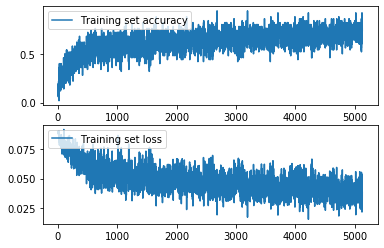

In [24]:
# X-AXIS BATCHES, Y-AXIS ACCURACY(0-1)
def plot_accuracy_loss():
        fig = plt.figure()
        ax1 = plt.subplot2grid((2,1), (0,0))
        ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
        ax1.plot(accuracy_list, label="Training set accuracy")
        ax1.legend(loc=2)
        ax2.plot(loss_list, label="Training set loss")
        ax2.legend(loc=2)
        plt.show()
        
plot_accuracy_loss()



---



Image Net Pre Trained Network

  0%|          | 0/10 [00:00<?, ?it/s]


 EPOCH NUMBER:  0


 10%|█         | 1/10 [00:55<08:18, 55.34s/it]


 EPOCH NUMBER:  1


 20%|██        | 2/10 [01:50<07:22, 55.32s/it]


 EPOCH NUMBER:  2


 30%|███       | 3/10 [02:45<06:27, 55.30s/it]


 EPOCH NUMBER:  3


 40%|████      | 4/10 [03:41<05:31, 55.29s/it]


 EPOCH NUMBER:  4


 50%|█████     | 5/10 [04:36<04:36, 55.27s/it]


 EPOCH NUMBER:  5


 60%|██████    | 6/10 [05:31<03:41, 55.27s/it]


 EPOCH NUMBER:  6


 70%|███████   | 7/10 [06:26<02:45, 55.25s/it]


 EPOCH NUMBER:  7


 80%|████████  | 8/10 [07:21<01:50, 55.21s/it]


 EPOCH NUMBER:  8


 90%|█████████ | 9/10 [08:17<00:55, 55.20s/it]


 EPOCH NUMBER:  9


100%|██████████| 10/10 [09:12<00:00, 55.22s/it]



 TRAINING COMPLETED

 TESTING COMPLETED

 TEST SET ACCURACY:  0.9177777777777778


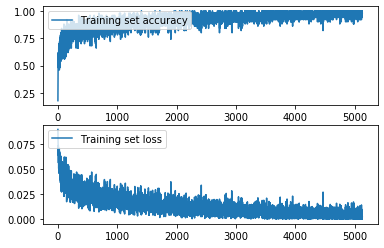

In [25]:
#USING PRETRAINED RESNET18 MODEL
resnet18 = models.resnet18(pretrained=True)
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

#CHANGING DIMENSIONS OF FC LAYER TO OUTPUT 10 CLASSES
fc_inputs = resnet18.fc.in_features

#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(fc_inputs,100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100,10)),
    ('output', nn.Softmax(dim=1))
]))

resnet18.fc = fc

#CHANGE INPUT OF FIRST CONV LAYER - 1 CHANNEL, 64 FILTERS
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3)
resnet18 = resnet18.to(device)
accuracy_list=[]
loss_list=[]
train(resnet18)
test(resnet18)
plot_accuracy_loss()



---



Visualizing first layer kernels

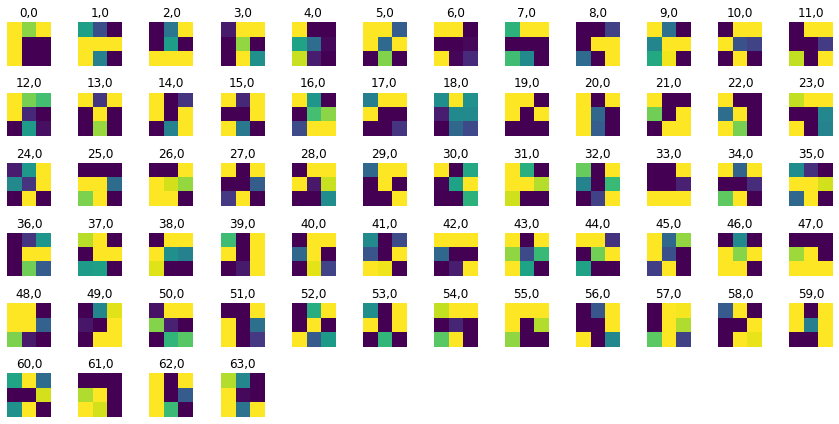

In [26]:
def plot_filters(t):
    
    #KERNEL DEPTH * NO. OF KERNELS
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols

    #CONVERT TENSOR TO IMAGE
    npimg = np.array(t.numpy(), np.float32)
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #LOOPING THROUGH ALL THE KERNELS
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num):
  
  #EXTRACTING MODEL FEATURES IN A LAYER
  layer = model.conv1
  
  #CHECK IF IT IS CONV LAYER 
  if isinstance(layer, nn.Conv2d):
    #GETTING WEIGHT DATA
    weight_tensor = model.conv1.weight.data
    
    plot_filters(weight_tensor)
        
#VISULAIZE WEIGHTS FOR RESNET 1st CONV LAYER
plot_weights(resnet18.cpu(), 1)